# Preamble

In [1]:
import numpy as np
import spinmob as s

In [2]:
from sympy import sympify
from scipy.optimize import minimize

Load in data (1=rigel, 2=joseph, 3=miles) and convert inches to cm:

In [5]:
datafilenames = ["calibration_data"+str(i)+".csv" for i in range(1, 4)]
calibration_datas = [s.data.load(datafilename) for datafilename in datafilenames]
added_voltage_error = 0#0.05
inch_to_cm = 2.54
for calibration_data in calibration_datas:
    calibration_data[0] *= inch_to_cm
    calibration_data[2] *= inch_to_cm
    calibration_data[3] += added_voltage_error

Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: errors
Extra ckey: Height
Extra ckey: error
Extra ckey: Voltage
Extra ckey: measurements?)
Extra ckey: bad
Extra ckey: to
Extra ckey: due
Extra ckey: 0.003
Extra ckey: to
Extra ckey: up
Extra ckey: take
Extra ckey: (maybe
Extra ckey: errors
Extra ckey: Height


Convert to relative heights:

In [6]:
for calibration_data in calibration_datas:
    calibration_data[0] -= np.max(calibration_data[0])
    calibration_data[0] *= -1
    calibration_data[2] *= 2

Offset the data for maximal overlap:

In [11]:
second_calibration_offset = -0.0327775555555
third_calibration_offset = -0.0594444444445
calibration_datas[1][0] -= second_calibration_offset
calibration_datas[2][0] -= third_calibration_offset

Chop data so they have some all overlapping:

In [14]:
for calibration_data in calibration_datas:
    max_range = np.argmin(np.abs(calibration_data[0] - 0.45))+1
    for i in range(4):
        calibration_data[i] = calibration_data[i][:max_range]

Generate plots for each:

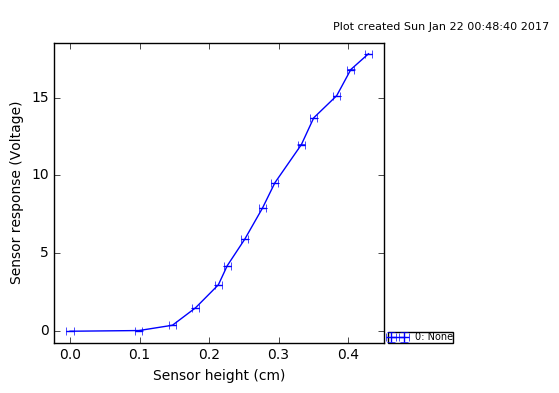

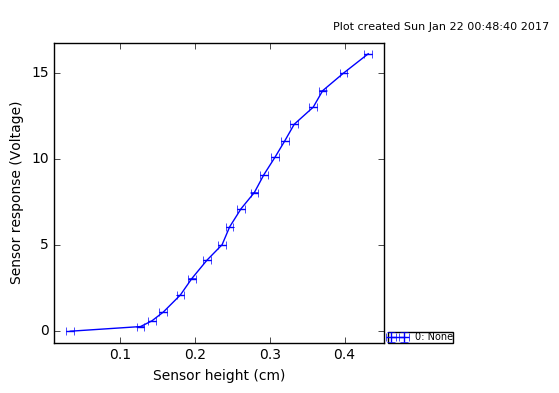

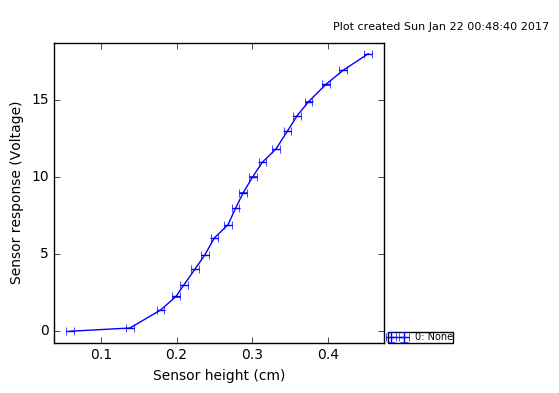

In [15]:
for i, calibration_data in enumerate(calibration_datas):
    fig = s.pylab.figure()
    ax = fig.add_axes([0,0,1,1])
    s.plot.xy.data(
        xdata=calibration_data[0], ydata=calibration_data[1],
        exdata=calibration_data[2], eydata=calibration_data[3],
        xlabel="Sensor height (cm)", ylabel="Sensor response (Voltage)")
    #s.pylab.savefig("calibration_curve"+str(i+1)+".pdf", bbox_inches='tight')

Try to overlap using polynomials:

Try to produce some linear fits:

In [61]:
def obtain_fit_results(calibration_data):
    chi_squares = []
    fits = []
    for start in range(0, 11):
        for length in range(3, len(calibration_data[0])-start):
            my_fitter = s.data.fitter(f='a*x + b', p='a, b')
            my_fitter._settings['autoplot'] = False
            length_of_regression = length
            start_of_regression = start
            end_of_regression = start_of_regression + length_of_regression
            my_fitter.set_data(
                xdata=calibration_data[0][start_of_regression:end_of_regression],
                ydata=calibration_data[1][start_of_regression:end_of_regression],
                exdata=calibration_data[2][start_of_regression:end_of_regression],
                eydata=calibration_data[3][start_of_regression:end_of_regression])
            my_fitter.fit()
            chi_squared = my_fitter.reduced_chi_squareds()[0]
            chi_squares.append([start, length, chi_squared])
            fits.append(my_fitter.results[0])
    return chi_squares, fits

In [62]:
all_fit_data = [obtain_fit_results(calibration_datas[i]) for i in range(3)]
chi_squares = [np.array(all_fit_data[i][0]) for i in range(3)]
best_fits = [np.argsort(np.abs(chi_squares[i][:, 2]-1)) for i in range(3)]
fit_params = [np.array(all_fit_data[i][1]) for i in range(3)]

In [95]:
for i in range(3):
    print("Curve", i)
    for j in range(10):
        print("Start, length, reduced chi-square:", fit_results[i][best_fits[i][j]])
        pass

Curve 0
Start, length, reduced chi-square: [   6.            3.          117.64611872]
Start, length, reduced chi-square: [   5.     3.   121.5]
Start, length, reduced chi-square: [   4.            4.          185.33898305]
Start, length, reduced chi-square: [   4.            5.          225.33697887]
Start, length, reduced chi-square: [   2.      3.    230.64]
Start, length, reduced chi-square: [   0.            3.          294.23518109]
Start, length, reduced chi-square: [   5.            4.          302.48170366]
Start, length, reduced chi-square: [   4.            7.          323.37672157]
Start, length, reduced chi-square: [   4.            6.          345.33029551]
Start, length, reduced chi-square: [   5.            5.          347.99141492]
Curve 1
Start, length, reduced chi-square: [ 10.           5.          20.96135609]
Start, length, reduced chi-square: [ 10.           4.          29.59417808]
Start, length, reduced chi-square: [  4.           3.          47.04054054]
Start

Try to increase a fake error to get realistic chi-squared values:

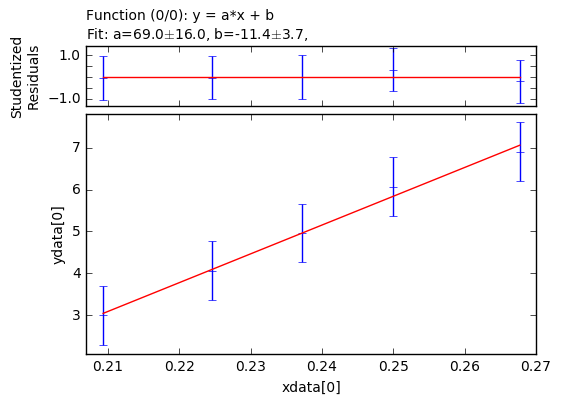

Voltage error: 0.698876327365
Chi^2: 0.0548219845463


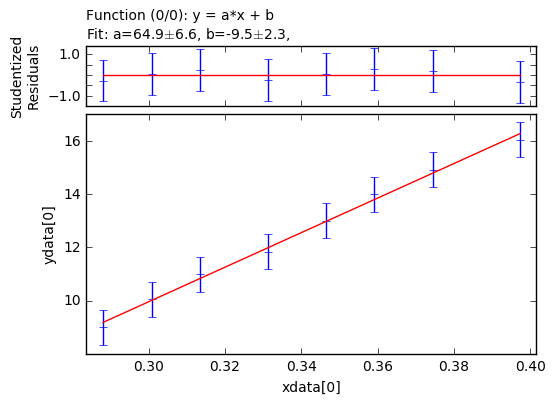

Voltage error: 0.658783946878
Chi^2: 0.0732660486782


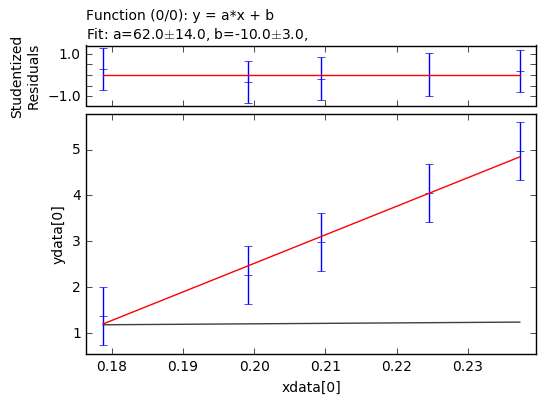

Voltage error: 0.633732402641
Chi^2: 0.084074478993


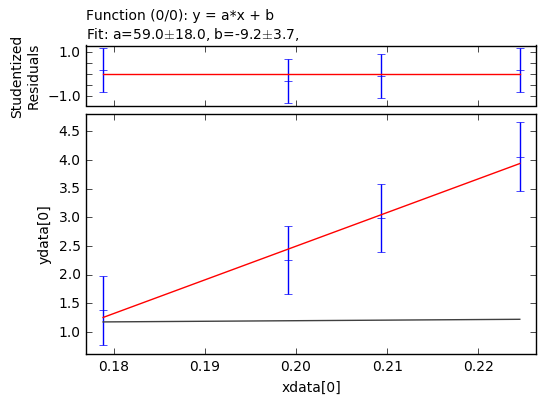

Voltage error: 0.59675231603
Chi^2: 0.0961994179087


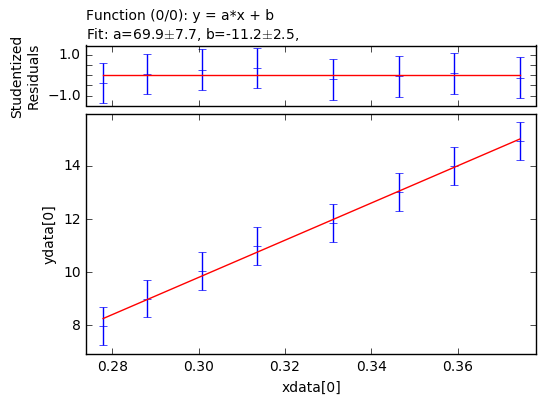

Voltage error: 0.708527108001
Chi^2: 0.0683765562831


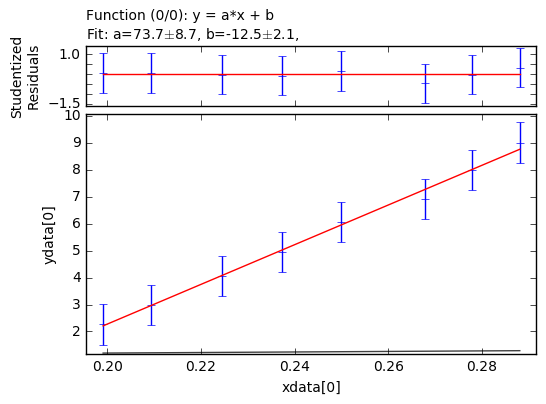

Voltage error: 0.746893110302
Chi^2: 0.0622625884579


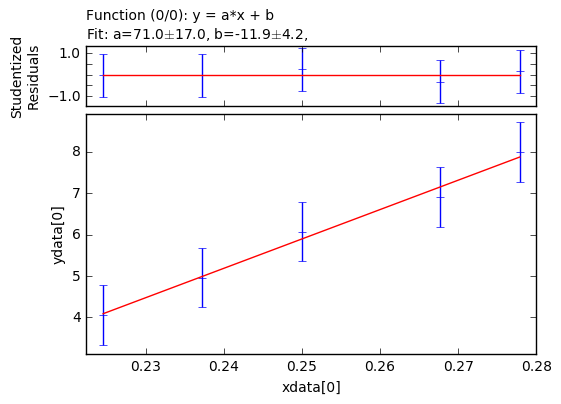

Voltage error: 0.719869912622
Chi^2: 0.0682939493315


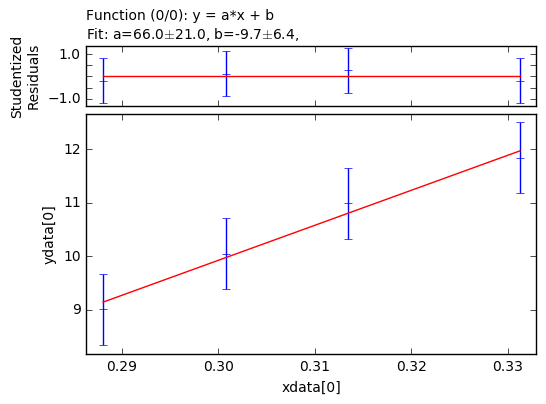

Voltage error: 0.665586559658
Chi^2: 0.0837014984333


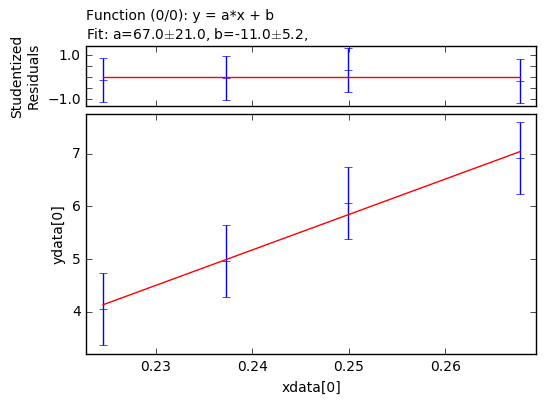

Voltage error: 0.682032291211
Chi^2: 0.0801037585464


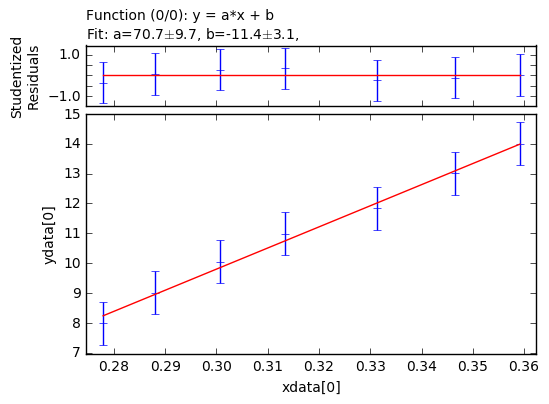

Voltage error: 0.717201553904
Chi^2: 0.0754409257755


In [131]:
curve_number = 2
for i in range(20,30):
    calibration_datas[curve_number][3][:] = 0.01
    current_slope = fit_params[curve_number][best_fits[curve_number][i]][0]
    temp_voltage_error = calibration_datas[curve_number][3]*(current_slope+1)
    calibration_datas[curve_number][3][:] = temp_voltage_error[:]
    
    
    my_fitter = s.data.fitter(f='a*x + b', p='a, b')
    my_fitter._settings['autoplot'] = False
    length_of_regression = fit_results[curve_number][best_fits[curve_number][i]][1]
    start_of_regression = fit_results[curve_number][best_fits[curve_number][i]][0]
    end_of_regression = start_of_regression + length_of_regression
    
    my_fitter.set_data(
        xdata=calibration_datas[curve_number][0][start_of_regression:end_of_regression],
        ydata=calibration_datas[curve_number][1][start_of_regression:end_of_regression],
        exdata=calibration_datas[curve_number][2][start_of_regression:end_of_regression],
        eydata=calibration_datas[curve_number][3][start_of_regression:end_of_regression])
    
    my_fitter.fit()
    my_fitter.plot()
    print("Voltage error:", calibration_datas[curve_number][3][0])
    print("Chi^2:", my_fitter.reduced_chi_squareds()[0])
    calibration_datas[curve_number][3][:] = 0.01

In [130]:
calibration_datas[2][3][:]

array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01])